In [1]:
import numpy as np 
import os
import glob
import shutil
import cv2
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau, EarlyStopping
from keras import backend as keras
from keras import backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import datetime
from moviepy.editor import VideoFileClip, clips_array, vfx
import math
import matplotlib.pyplot as plt

# import tensorflow_addons as tfa

**Loading U-Net model**

In [2]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x
  
def get_unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [3]:
inputs = Input((256,256,3))
unet_model = get_unet(inputs, n_filters = 16, dropout = 0.1, batchnorm = True)

unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy',
              tf.keras.metrics.Recall(name="recall"),
              tf.keras.metrics.Precision(name="precision"),
              tf.keras.metrics.MeanIoU(num_classes=2, name='iou')])
unet_model.load_weights('../ckpt/Model-Unet-20000-16-crossEntr-256_RGB_80epochs_16fsize.h5')

**Preparing YoLov4 Implementation**

In [4]:
import time
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np



CONFIDENCE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.4
impath = ""

weights = "C:/Users/moham/Downloads/yolo-obj_10000.weights"
labels = "C:/Users/moham/Downloads/obj_1.names"
cfg = "C:/Users/moham/Carla/yolov4/Darknet/cfg/yolo-obj.cfg"

print("You are now using {} weights ,{} configs and {} labels.".format(weights, cfg, labels))

lbls = list()
with open(labels, "r") as f:
    lbls = [c.strip() for c in f.readlines()]
COLORS = np.array([[ 81, 228, 126],
       [149, 135, 128],
       [ 18,  90, 186],
       [110, 139,  20],
       [133, 151, 170],
       [ 18, 104, 223],
       [100, 144, 135],
       [187, 223,  18],
       [116, 119, 186]], dtype=np.uint8)
# COLORS = np.random.randint(0, 255, size=(len(lbls), 3), dtype="uint8")

nn = cv2.dnn.readNetFromDarknet(cfg, weights)
nn.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
nn.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)

layer = nn.getLayerNames()
layer = [layer[i - 1] for i in nn.getUnconnectedOutLayers()]


def detect(image):
#     image = cv2.imread(imgpath)
    (H, W) = image.shape[:2]
    
    org_image = image.copy()
    
    blob = cv2.dnn.blobFromImage(image, 1 / 255, (416, 416), swapRB=True, crop=False)
    nn.setInput(blob)
    start_time = time.time()
    layer_outs = nn.forward(layer)
    end_time = time.time()

    boxes = list()
    confidences = list()
    class_ids = list()

    for output in layer_outs:
        for detection in output:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]

            if confidence > CONFIDENCE_THRESHOLD:
                box = detection[0:4] * np.array([W, H, W, H])
                (center_x, center_y, width, height) = box.astype("int")

                x = int(center_x - (width / 2))
                y = int(center_y - (height / 2))

                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                class_ids.append(class_id)

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, CONFIDENCE_THRESHOLD, NMS_THRESHOLD)
    if len(idxs) > 0:
        for i in idxs.flatten():
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            color = [int(c) for c in COLORS[class_ids[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
           
            bbox_mess = '%s: %.2f' % (lbls[class_ids[i]], confidences[i])
            t_size = cv2.getTextSize(bbox_mess, 0, 0.5, thickness=1)[0]
            c3 = (x + t_size[0], y - t_size[1] - 3)
            cv2.rectangle(image, (x, y), (int(np.float32(c3[0])), int(np.float32(c3[1]))), color, -1) #filled

            cv2.putText(image, bbox_mess, (x, int(np.float32(y - 2))), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, (0, 0, 0), 1, lineType=cv2.LINE_AA)
            label = "Inference Time: {:.2f} s".format(end_time - start_time)
#             cv2.putText(
#                 image, label, (0, 25), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2
#             )
#             image = cv2.addWeighted(image, 1, predict_unet(org_img, unet_model_256, 256), 0.3, 0)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             cv2.imwrite("C:/Users/moham/Downloads/image1.jpg", image)
    return image




You are now using C:/Users/moham/Downloads/yolo-obj_10000.weights weights ,C:/Users/moham/Carla/yolov4/Darknet/cfg/yolo-obj.cfg configs and C:/Users/moham/Downloads/obj_1.names labels.


**Preparing drivable area utils**

In [5]:
def aoi(org_img, pts_l, pts_r):
    aoi_mask = np.zeros_like(org_img)
    rows, cols = org_img.shape[:2]
    left_bottom = pts_l[1]
    right_bottom = pts_r[1]
    left_top = pts_l[0]
    right_top = pts_r[0]
#     left_bottom = [cols * 0.1, rows]
#     right_bottom = [cols * 0.8, rows]
#     left_top = [cols * 0.25, rows * 0.4]
#     right_top = [cols * 0.8, rows * 0.4]
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    cv2.fillPoly(aoi_mask, vertices, (255, 255, 255))

    aoi = cv2.bitwise_and(org_img, aoi_mask)
    return aoi

def aoi_inv(org_img, pts_l, pts_r):
    aoi_mask = np.ones_like(org_img)*255
    rows, cols = org_img.shape[:2]
    left_bottom = pts_l[1]
    right_bottom = pts_r[1]
    left_top = pts_l[0]
    right_top = pts_r[0]
    # left_bottom = [cols * 0.18, rows]
    # right_bottom = [cols * 0.91, rows]
    # left_top = [cols * 0.45, rows * 0.7]
    # right_top = [cols * 0.58, rows * 0.7]
    vertices = np.array([[left_bottom, left_top, right_top, right_bottom]], dtype=np.int32)
    cv2.fillPoly(aoi_mask, vertices, (0, 0, 0))

    aoi = cv2.bitwise_and(org_img, aoi_mask)
    return aoi

def get_line_slope_intercept(line):
    x1, y1, x2, y2 = line
    if x2 - x1 == 0:
        return math.inf, 0
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1
    return slope, intercept

def convert_slope_intercept_to_line(y1, y2, line):
    if line is None:
        return None

    slope, intercept = line
    x1 = int((y1 - intercept) / slope)
    y1 = int(y1)
    x2 = int((y2 - intercept) / slope)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))



In [6]:
img_number = "0cca3543-9d44351e"
img_path = "Unet_test_on_data_val/"+img_number+".jpg"
img_path_label = "Unet_test_on_data_val-labels/"+img_number+".jpg"

**U-Net function**

In [7]:
# org_img = cv2.imread(img_path)

def predict(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    org_img = image.copy()
    dimensions = org_img.shape[::-1][1:3]

    img = cv2.resize(org_img, (256,256))
    small_img = img/255
    small_img = small_img[None,:,:]
    h = unet_model.predict(small_img)
    h = (h[0]>0.8).astype(np.uint8)*255

    h = cv2.resize(h,dimensions)
    edges = cv2.Canny(h, 50, 200)
    
    lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=40, minLineLength=10, maxLineGap=250)
    # Draw lines on the image
    l = dict()
    for line in lines:
        x1, y1, x2, y2 = line[0]
        slope = get_line_slope_intercept(line[0])
        l[slope] = x1, y1, x2, y2
#         cv2.line(edges, (x1, y1), (x2, y2), (255, 0, 0), 5)

    l_s = list(l.keys())
    l_s.sort(key=lambda x:x[0]) 
    left_lines = list()
    right_lines = list()
    for line in l_s:
        x1, y1, x2, y2 = l[line]
#         cv2.line(edges, (x1, y1), (x2, y2), (255, 0, 0), 5)
        if (line[0]<-0.2)or(line[0]>0.2):

            slope, intercept = line[0], line[1]
            if slope == math.inf:
                continue

            if slope < 0:
                left_lines.append((slope, intercept))

            else:
                right_lines.append((slope, intercept))
#     plt.imshow(edges)
#     plt.show()

    left_lines = [left_lines[k] for k in range(len(left_lines)) if abs(left_lines[k][0]-left_lines[k-1][0])>0.1]
    right_lines = [right_lines[k] for k in range(len(right_lines)) if abs(right_lines[k][0]-right_lines[k-1][0])>0.1]
    left_lines.sort(key=lambda x:x[1])
    right_lines.sort(key=lambda x:x[1])

    try:
#         print(left_lines[len(left_lines)-1])
        x1, y1, x2, y2 = l[left_lines[len(left_lines)-1]]
        cv2.line(edges, (x1, y1), (x2, y2), (255, 0, 0), 5)
    except:
        print('no left')

    try:
#         print(left_lines[0])
        x1, y1, x2, y2 = l[right_lines[0]]
        cv2.line(edges, (x1, y1), (x2, y2), (255, 0, 0), 5)
    except:
        print('no right')
#     plt.imshow(edges)
#     plt.show()
    
    try:
        pts_r = convert_slope_intercept_to_line(h.shape[0], min(y1, y2), right_lines[0])
        pts_l = convert_slope_intercept_to_line(h.shape[0], min(y1, y2), left_lines[len(left_lines)-1])

        h = cv2.resize(h,dimensions)
        edges = cv2.Canny(h, 50, 200)
        cv2.line(edges, pts_l[0], pts_l[1], (255, 0, 0), 5)
        cv2.line(edges, pts_r[0], pts_r[1], (255, 0, 0), 5)
        h = cv2.resize(h, (org_img.shape[1], org_img.shape[0]))
        blanks = np.zeros_like(h).astype(np.uint8)
        lane_drawn = np.dstack((aoi_inv(h, pts_l, pts_r), aoi(h, pts_l, pts_r), blanks))
    except:
        h = cv2.resize(h, (org_img.shape[1], org_img.shape[0]))
        blanks = np.zeros_like(h).astype(np.uint8)
        lane_drawn = np.dstack((blanks, h, blanks))
    

    
    image_final = cv2.resize(lane_drawn,dimensions)
    final_int = image_final.astype(int)
    result = cv2.addWeighted(org_img, 1, np.uint8(final_int), 0.8, 0)
    
#     plt.imshow(result)
#     plt.show()


        # Re-size to match the original image
    # lane_image = cv2.resize(lane_drawn, (720, 1280, 3))


    return result

In [8]:
org_img = cv2.imread(r"../Unet_test_on_data_val/0aa842d5-a319d2e2.jpg")
# org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)

**Testing on both U-Net, drivable area and YoLo**

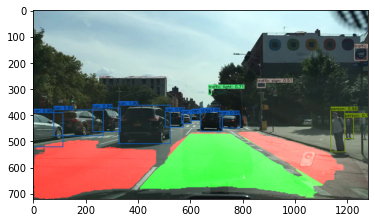

In [9]:
plt.imshow(detect(predict(org_img)))
plt.show()
